# Model Ensemble: Toy example

1. The objective is to combine different model and get uncertainty of estimates. 
2. We predict the median LE (`LA_uncertainty.dta`)
3. We use three different regression models: Ridge, Random Forest, K-Neighbors. We can include other such as logistic or boxcox.
4. The estimate is the first different in LE of increasing GDP 1 SD. 

In [471]:
# load packages
from sklearn.base import TransformerMixin
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.utils import resample
import sklearn.metrics as met
import numpy as np
import pandas as pd
from sklearn_pandas import DataFrameMapper, cross_val_score
from utils import utils as f # my functions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

Here it is the definition classes and models:

In [472]:
# define model transformers
class RidgeTransformer(Ridge, TransformerMixin):

    def transform(self, X, *_):
        return self.predict(X).reshape(-1,1)

class RandomForestTransformer(RandomForestRegressor, TransformerMixin):

    def transform(self, X, *_):
        return self.predict(X).reshape(-1,1)

class KNeighborsTransformer(KNeighborsRegressor, TransformerMixin):

    def transform(self, X, *_):
        return self.predict(X).reshape(-1,1)

I combine predictions generated from these models and use them to **predict** the actual outcome. I weight those predictions using linear regression, although I could use any other model (e.g., random forest, xgboost). For now, let's keep it simple. 

- Ridge regression is standardizing first, and then computing polynomial transformation of features
- Random Forest and K-Neighbors use default set up. 

In [473]:
# function to create model
def build_model():
    
    ridge_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('poly_feats', PolynomialFeatures()),
        ('ridge', RidgeTransformer())
    ])

    pred_union = FeatureUnion(
        transformer_list=[
            ('ridge', ridge_transformer),
            ('rand_forest', RandomForestTransformer()),
            ('knn', KNeighborsTransformer())
        ],
    )

    # return combination of predictions
    model = Pipeline(steps=[
        ('pred_union', pred_union),
        ('lin_regr', LinearRegression()) # linear combination
    ])

    return model

In [474]:
test = RidgeTransformer()

In [475]:
test.fit(X_train, y_train)

RidgeTransformer(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
         normalize=False, random_state=None, solver='auto', tol=0.001)

# Run an individual example

In [476]:
# read the data
df = pd.read_stata('../data/LA_uncertainty.dta')

# select variables
df = df.loc[:, ['year', 'ctry', 'gdp_pc', 'median']]

In [477]:
# some missing data
f.missing_data(df)

gdp_pc    0.101828
median    0.002611
dtype: float64

In [478]:
# remove missing data

In [479]:
df = df.dropna()
df.shape # 343 

(343, 4)

In [480]:
# slected features
X, y = df['gdp_pc'].as_matrix().reshape(-1, 1), df['median'].as_matrix()

# define training set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    stratify=df.ctry)

In [481]:
# instance of model and fit
model = build_model()
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pred_union', FeatureUnion(n_jobs=1,
       transformer_list=[('ridge', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly_feats', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', RidgeTransformer(...=None)), ('lin_regr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [482]:
# predictions 
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

In [483]:
# overfitting in action
print('MSE training: ', str(met.mean_squared_error(y_train, pred_train)))
print('MSE test: ', str(met.mean_squared_error(y_test, pred_test)))

MSE training:  29.2989573467
MSE test:  239.216671725


In [484]:
# counterfactual and first difference

In [485]:
X_train_cf = X_train + np.std(X_train) # + 1 SD GDP
pred_train_cf = model.predict(X_train_cf)
print('Mean first difference: ', str(np.mean(pred_train_cf - pred_train)))

Mean first difference:  13.122100359


# Uncertainty

The easiest way to do it is to bootstrap the estimates for the first difference. 

Pretty straightforward functions to do it. 

In [486]:
# bootstrap function
def bootstrap(estimator, X, y, samples=1000, sample_size=.70): 
    
    # list to save results
    stats = []
    nrows = y.shape[0]
    
    # loop
    for s in range(0, samples):
        idx = np.random.choice(nrows, int(len(y)*sample_size), replace=True)
        ty = y[idx]
        tX = X[idx]
        
        model.fit(tX, ty)
        pred = model.predict(tX)
        pred_cf = model.predict(tX + np.std(tX))
        stats.append(np.mean(pred_cf-pred))
    return stats

In [487]:
estimates = bootstrap(model, X_train, y_train, samples=2000, sample_size=0.50)

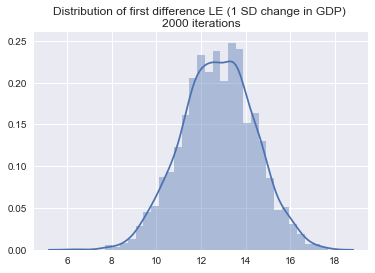

In [488]:
sns.distplot(estimates)
plt.title('Distribution of first difference LE (1 SD change in GDP) \n2000 iterations');